# PoseNet 2D to Kinect 2D

In [1]:
import os
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
posenetDataPath = '../../datasets/posenet-uncut/'
kinectDataPath = '../../datasets/kinect_good_preprocessed_not_cut/'

X = None
y = None

train_test_ratio = 0.8
random_state = 47

# Model parameters
units = 64
activation = 'relu'
output_layer = ''
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
loss = 'mse'
metrics = ['mae']
epochs = 500
batch_size = 16

## 1. Data Preparation

### Load matching files from PoseNet and Kinect

In [3]:
import re

for file in os.listdir(posenetDataPath):
    if file.endswith('.csv'):
        try:
            posenetData = pd.read_csv(posenetDataPath + file)
            kinectData = pd.read_csv(kinectDataPath + '{}_kinect.csv'.format(file.replace('.csv', '')))
            # Check amount of frames
            if (len(posenetData) == len(kinectData)):
                posenetData.drop(columns=['FrameNo'], inplace=True)
                if X is None:
                    X = posenetData
                else:
                    X = pd.concat((X, posenetData), ignore_index=True)

                # Drop Z-columns from Kinect
                z = []
                for c in kinectData.columns:
                    if re.search("^.*_z$", c):
                        z.append(c)
                kinectData.drop(columns=z, inplace=True)
                kinectData.drop(columns=['FrameNo'], inplace=True)
                if y is None:
                    y = kinectData
                else:
                    y = pd.concat((y, kinectData), ignore_index=True)
        except IOError as e:
            print('Error in reading file: ', e)

print(X.shape)
print(y.shape)

(30502, 26)
(30502, 26)


### Training and test split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(X, y, train_size=train_test_ratio, random_state=random_state)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(24401, 26)
(24401, 26)
(6101, 26)
(6101, 26)


### Scaling

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[-0.27495994, -0.26773764, -0.34432833, ..., -0.34883442,
        -0.58006339, -0.24141234],
       [ 1.12571837, -1.12601649,  0.76471187, ..., -0.13458797,
        -0.51606205, -0.23704848],
       [-0.7464662 ,  0.53853235, -0.9152584 , ...,  0.28876792,
        -1.33867572,  0.82637654],
       ...,
       [-0.23958541,  0.21279773, -0.3489995 , ..., -0.01750024,
        -0.70755953,  0.42285945],
       [-0.23776884, -0.61749004, -0.31000717, ..., -0.24018406,
         1.05727403, -1.26829454],
       [-0.44383449, -0.36911555, -0.40507922, ..., -0.34225154,
        -0.81226638, -0.16403101]])

## 2. DL Model

### Model Architecture

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

model = Sequential([
    Input(shape=(X_train.shape[1])),
    Dense(units=units, activation=activation),
    Dense(units=units, activation=activation)
])
if not output_layer:
    model.add(Dense(units=X_train.shape[1]))
else:
    model.add(Dense(units=X_train.shape[1], activation=output_layer))
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1728      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 26)                1690      
Total params: 7,578
Trainable params: 7,578
Non-trainable params: 0
_________________________________________________________________


### Early stopping

In [7]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=20,
    mode='min',
    restore_best_weights=True)

### Model Training

In [8]:
history = model.fit(x=X_train, y=y_train, validation_split=0.2, shuffle=True, epochs=epochs, verbose=1, batch_size=batch_size, callbacks=[early_stopping])

training_history = pd.DataFrame(history.history)
training_history['epochs'] = range(len(training_history['mae']))

Epoch 1/500
1220/1220 [==============================] - 2s 908us/step - loss: 5344.4063 - mae: 23.3876 - val_loss: 17.9892 - val_mae: 2.9875
Epoch 2/500
1220/1220 [==============================] - 1s 731us/step - loss: 15.6530 - mae: 2.8026 - val_loss: 8.9789 - val_mae: 2.0990
Epoch 3/500
1220/1220 [==============================] - 1s 730us/step - loss: 8.4942 - mae: 2.0681 - val_loss: 5.3452 - val_mae: 1.6324
Epoch 4/500
1220/1220 [==============================] - 1s 714us/step - loss: 5.3549 - mae: 1.6694 - val_loss: 3.5756 - val_mae: 1.3490
Epoch 5/500
1220/1220 [==============================] - 1s 706us/step - loss: 3.3899 - mae: 1.3462 - val_loss: 2.0968 - val_mae: 1.0484
Epoch 6/500
1220/1220 [==============================] - 1s 714us/step - loss: 2.0080 - mae: 1.0371 - val_loss: 1.7041 - val_mae: 0.9638
Epoch 7/500
1220/1220 [==============================] - 1s 716us/step - loss: 1.3478 - mae: 0.8574 - val_loss: 1.3447 - val_mae: 0.8869
Epoch 8/500
1220/1220 [============

### Plot training and validation MAE & loss per epoch

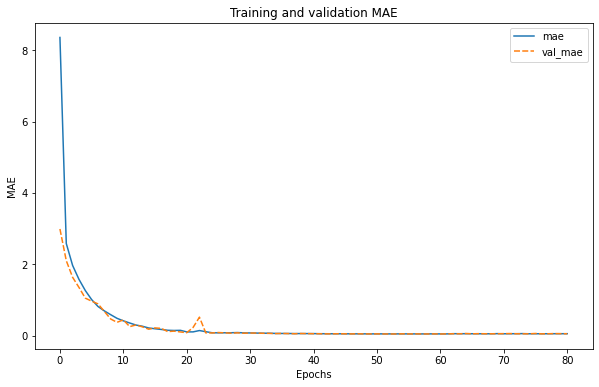

In [9]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=training_history[['mae', 'val_mae']])
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

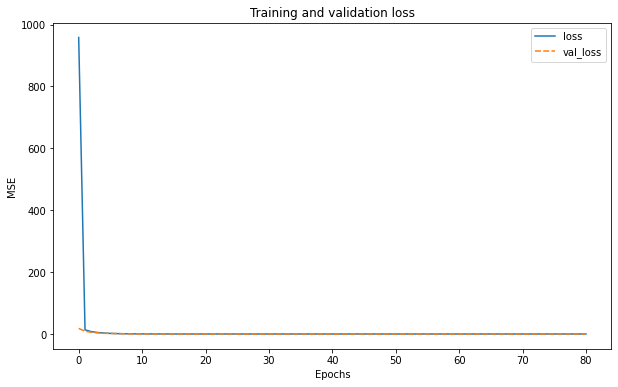

In [10]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=training_history[['loss', 'val_loss']])
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

### Predictions

In [11]:
predictions = model.predict(x=X_test, verbose=1)

191/191 [==============================] - 0s 375us/step


In [12]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

print('MSE: ', mean_squared_error( y_test, predictions ))
print('MSA: ', mean_absolute_error( y_test, predictions ))
print('R-Squared: ', r2_score( y_test, predictions ))
print('Explained Variance Score: ', explained_variance_score( y_test, predictions ))

MSE:  0.004165439176183083
MSA:  0.043307989473954984
R-Squared:  0.6961501386406604
Explained Variance Score:  0.7042667944339939
